In [1]:
import torch
import torchaudio
import librosa
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt
torch.__version__,torchaudio.__version__

('1.10.2', '0.10.2')

# TorchAudio介绍和使用方法


## 简介
TorchAudio可以理解为是pytorch在音频领域的一个扩展，它以pytorch为基础，将pytorch的理念延伸到音频领域，例如与pytorch具有一致的风格（张量名和维度）还提供了 GPU 加速的功能，并且可以通过 autograd 进行特征的训练。与传统的音频信号处理库相比，TorchAudio更像一个机器学习库，而不是通用的信号处理库。

## TorchAudio的主要功能
1. 通过 SoX 将各种音频格式（如 wav、mp3、ogg、flac、opus、sphere）加载为 Torch Tensor ，这样就可以方便下游程序处理
2. 提供了Spectrogram、AmplitudeToDB、MelScale、MelSpectrogram、MFCC、MuLawEncoding、MuLawDecoding、Resample等常见的音频转换
3. 与其他音频库对齐的函数：spectrogram, fbank, mfcc
4. 与torchvision 类似，提供了常用音频数据集

说到 SoX，这里再多说两句：Sound eXchange 是一个跨平台（Windows，Linux，MacOS 等）的命令行程序，可以将各种格式的音频文件转换为需要的其他格式，可以说他就是音频界的ffmpeg（如果你对视频熟悉的话，这个名字你一定知道）

## 与Librosa对比
Librosa是一个用于音频、音乐分析和处理的python工具包，Librosa是Python中我最常用的音频处理库了：一些常见的时频处理、特征提取、绘制声音图形等功能应有尽有，功能十分强大，所以在下面的介绍中会和Librosa做一些对比。除Librosa以外，还有nnAudio可以选择这里就不多介绍了，有兴趣的可以搜索下。

## 读取音频文件信息
第一步肯定是要读取文件，所以这里我使用的winxp的开机声音作为样例文件，如果你是用过XP的话这个声音应当很熟悉。
但是在读取文件之前，可以先看一下音频文件的信息。

In [2]:
meta=torchaudio.info('winxp.wav')
print(meta)

AudioMetaData(sample_rate=44100, num_frames=177152, num_channels=2, bits_per_sample=16, encoding=PCM_S)


In [3]:
meta=torchaudio.info('p232_023.wav')
print(meta) 

AudioMetaData(sample_rate=48000, num_frames=468905, num_channels=1, bits_per_sample=16, encoding=PCM_S)


## 加载文件
看到了文件信息，我可以可以加载文件并试听文件的内容了，下面的代码都会包含TorchAudio和Librosa两个版本，这样可以方便进行对比和验证，因为torchaudio中代码的测试样例也是使用了librosa进行的验证，所以我们这里也这样使用

In [4]:
ta_wav1,ta_sr1=torchaudio.load('winxp.wav')
ta_wav1.shape,ta_sr1


(torch.Size([2, 177152]), 44100)

In [5]:
lr_wav1,lr_sr1=librosa.load('winxp.wav')
lr_wav1.shape,lr_sr1

((88576,), 22050)

这里shape为(2，n)是立体声，(n，)则是单声道。因为librosa的默认值是采样率为 22050，并且是单声道mono=True，所以设置sr为None可以使用文件自己的采样率，mono=False设置为非单声道，这样数据的大小就相同了。

In [6]:
lr_wav1,lr_sr1=librosa.load('winxp.wav',sr=None,mono=False)
lr_wav1.shape,lr_sr1

((2, 177152), 44100)

In [7]:
lr_wav1[0,107152:107152+10],lr_wav1.dtype

(array([0.06680298, 0.07147217, 0.07409668, 0.08370972, 0.10314941,
        0.12136841, 0.13638306, 0.1539917 , 0.15390015, 0.15539551],
       dtype=float32),
 dtype('float32'))

In [8]:
ta_wav1[0,107152:107152+10],ta_wav1.dtype

(tensor([0.0668, 0.0715, 0.0741, 0.0837, 0.1031, 0.1214, 0.1364, 0.1540, 0.1539,
         0.1554]),
 torch.float32)

librosa 的数据是numpy的ndarray，而 torchaudio直接转换为tensor，二者都是 float32,小数位不一样其实并不是不准确而是显示的问题：

In [9]:
torch.tensor(lr_wav1)[0,107152:107152+10],ta_wav1[0,107152:107152+10].numpy()

(tensor([0.0668, 0.0715, 0.0741, 0.0837, 0.1031, 0.1214, 0.1364, 0.1540, 0.1539,
         0.1554]),
 array([0.06680298, 0.07147217, 0.07409668, 0.08370972, 0.10314941,
        0.12136841, 0.13638306, 0.1539917 , 0.15390015, 0.15539551],
       dtype=float32))

## 音频试听
对于 jupyter notebook，可以使用Audio进行音频文件的试听，传入的参数是刚才我们读取的音频文件和采样率下面是代码：

In [10]:
Audio(data=ta_wav1,rate=ta_sr1)

In [11]:
Audio(data=lr_wav1,rate=lr_sr1)

## 可视化
因为是双声道，所以我可以先显示2个声道的数据，使用load函数加载的数据被称为振幅图（amplitude）

([<matplotlib.lines.Line2D at 0x167316905c8>],
 [<matplotlib.lines.Line2D at 0x167087d8908>])

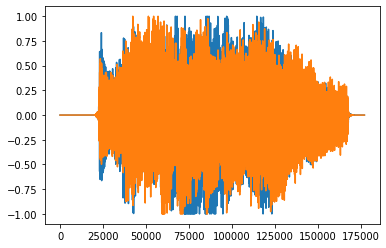

In [12]:
plt.plot(ta_wav1[0]),plt.plot(ta_wav1[1])

([<matplotlib.lines.Line2D at 0x167335f5708>],
 [<matplotlib.lines.Line2D at 0x167335ea988>])

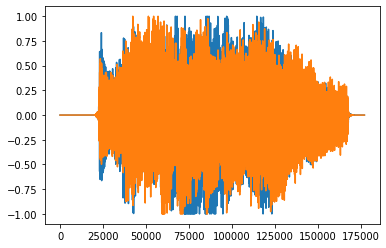

In [13]:
plt.plot(lr_wav1[0]),plt.plot(lr_wav1[1])

这就是我们加载的音频文件的数据的样子，2声道的数据还是略有不同的。本文后面为了简单起见，只是用第一个声道进行后面的操作和展示

## 音频特征的提取
上面显示了我们音频文件的最原始的样子，被称为音频信号的时域表示，但是只有10秒的文件需要17万的数据点，这么大的数据处理起来肯定是不现时的，这是就引出了音频信号的另外一种表示方式，频域表示。

- 时域： 自变量是时间 ，即横轴是时间， 纵轴是信号的变化（振幅 ）。
- 频域： 自变量是频率 ，即横轴是频率， 纵轴是该频率信号的幅度（振幅）。

对于频域的转换最好的方法就是快速傅立叶变换了（FFT），频域图可以被理解为是一堆相互堆叠的FFT，信号在不同频率下随时间变化时，可以直观地表示信号响度或幅度的方法，还可以减少数据量

In [14]:
w=np.random.randn(100)

In [15]:
lr_fft = np.abs(librosa.stft(lr_wav1,n_fft=1024,hop_length=512,win_length=100,window=w,center=True))
lr_fft.shape

(2, 513, 347)

In [16]:
ta_fft=ta_wav1.stft(n_fft=1024,hop_length=512,win_length=100,window=torch.tensor(w),center=True)
ta_rel=ta_fft[:,:,:,0]#实部
ta_imag=ta_fft[:,:,:,1]#虚部
# torch的stft函数返回包含实部和虚部，所以需要进行后续的计算
ta_fft=torch.abs(torch.sqrt(torch.pow(ta_rel,2)+torch.pow(ta_imag,2)))
ta_fft.shape

C:\Users\zergt\.conda\envs\cv10\lib\site-packages\torch\functional.py:573: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:659.)
  normalized, onesided, return_complex)


torch.Size([2, 513, 347])

In [17]:
lr_fft==ta_fft.numpy()

array([[[ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ..., False,  True,  True],
        ...,
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ..., False,  True,  True]],

       [[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]]])

In [18]:
lr_fft[0,0,-4:],ta_fft.numpy()[0,0,-4:],ta_fft.numpy().dtype

(array([8.9030458e-05, 4.2963817e-05, 0.0000000e+00, 0.0000000e+00],
       dtype=float32),
 array([8.90304578e-05, 4.29638165e-05, 0.00000000e+00, 0.00000000e+00]),
 dtype('float64'))

计算精度不一样。所以导致的一些差异,是正常范围的
引用pytorch的单元测试
`self.assertEqual(result, ref_result, atol=7e-6, rtol=0, msg='stft comparison against librosa', exact_dtype=False)` 可以看到atol范围内是ok的

进行傅里叶变换后，就可以进行频域的转换了

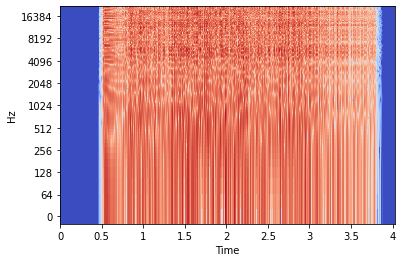

In [19]:
import librosa.display
lr_spec = librosa.amplitude_to_db(lr_fft, amin = 1e-10) 
librosa.display.specshow(lr_spec[0], sr=lr_sr1, x_axis='time', y_axis='log');

In [20]:
lr_spec

array([[[-57.7731, -57.7731, -57.7731, ..., -57.7731, -57.7731,
         -57.7731],
        [-57.7731, -57.7731, -57.7731, ..., -57.7731, -57.7731,
         -57.7731],
        [-57.7731, -57.7731, -57.7731, ..., -57.7731, -57.7731,
         -57.7731],
        ...,
        [-57.7731, -57.7731, -57.7731, ..., -57.7731, -57.7731,
         -57.7731],
        [-57.7731, -57.7731, -57.7731, ..., -57.7731, -57.7731,
         -57.7731],
        [-57.7731, -57.7731, -57.7731, ..., -57.7731, -57.7731,
         -57.7731]],

       [[-57.7731, -57.7731, -57.7731, ..., -57.7731, -57.7731,
         -57.7731],
        [-57.7731, -57.7731, -57.7731, ..., -57.7731, -57.7731,
         -57.7731],
        [-57.7731, -57.7731, -57.7731, ..., -57.7731, -57.7731,
         -57.7731],
        ...,
        [-57.7731, -57.7731, -57.7731, ..., -57.7731, -57.7731,
         -57.7731],
        [-57.7731, -57.7731, -57.7731, ..., -57.7731, -57.7731,
         -57.7731],
        [-57.7731, -57.7731, -57.7731, ..., -57.

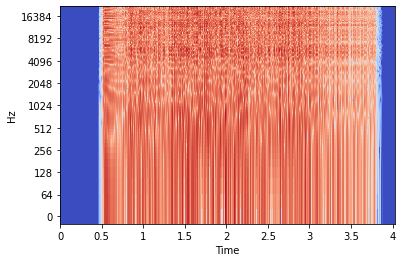

In [21]:
ta_spec=torchaudio.functional.amplitude_to_DB(ta_fft,  amin = 1e-10,multiplier = 20.0 ,db_multiplier=0.0,top_db = 80.0)
librosa.display.specshow(ta_spec.numpy()[0], sr=ta_sr1, x_axis='time', y_axis='log');

In [22]:
ta_spec

tensor([[[-57.7731, -57.7731, -57.7731,  ..., -57.7731, -57.7731, -57.7731],
         [-57.7731, -57.7731, -57.7731,  ..., -57.7731, -57.7731, -57.7731],
         [-57.7731, -57.7731, -57.7731,  ..., -57.7731, -57.7731, -57.7731],
         ...,
         [-57.7731, -57.7731, -57.7731,  ..., -57.7731, -57.7731, -57.7731],
         [-57.7731, -57.7731, -57.7731,  ..., -57.7731, -57.7731, -57.7731],
         [-57.7731, -57.7731, -57.7731,  ..., -57.7731, -57.7731, -57.7731]],

        [[-57.7731, -57.7731, -57.7731,  ..., -57.7731, -57.7731, -57.7731],
         [-57.7731, -57.7731, -57.7731,  ..., -57.7731, -57.7731, -57.7731],
         [-57.7731, -57.7731, -57.7731,  ..., -57.7731, -57.7731, -57.7731],
         ...,
         [-57.7731, -57.7731, -57.7731,  ..., -57.7731, -57.7731, -57.7731],
         [-57.7731, -57.7731, -57.7731,  ..., -57.7731, -57.7731, -57.7731],
         [-57.7731, -57.7731, -57.7731,  ..., -57.7731, -57.7731, -57.7731]]],
       dtype=torch.float64)

数值是一样的，所以这些操作计算的结果都是相同的，只不过两个包使用的默认参数不一样。但是通过我们手动更改参数，可以让两个框架的操作对齐

## mel频谱图
人类听觉的感知频率范围是有限的。 在低频差异方面要胜于高频。 人耳能听到的频率范围是20-20000Hz，但人耳对Hz这种标度单位并不是线性感知。例如把音调频率从1000Hz的提高到2000Hz，耳朵只能觉察到频率提高了一点点，所以1937年，Stevens，Volkmann和Newmann提出了一个音高单位，以使相等的音高距离听起来相等，也就是说，在该标度下，如果两段语音的频率相差两倍，则人耳可以感知到的音调大概也相差两倍。这个音高的单位被称为 梅尔（mel）音阶。

mel谱图是频率转换为mel标度的谱图，也是说mel谱图可以理解为最能够体现人类听觉的度量

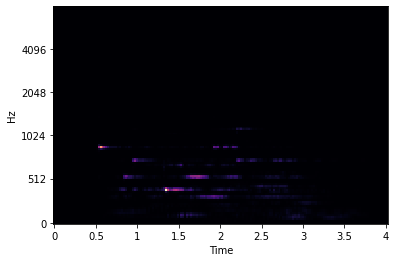

In [23]:
lr_mel_spect = librosa.feature.melspectrogram(y=lr_wav1, sr=lr_sr1, n_fft=2048, hop_length=1024,pad_mode="reflect",norm=None,htk=True)
librosa.display.specshow(lr_mel_spect[0], y_axis='mel', fmax=8000, x_axis='time');

In [24]:
lr_mel_spect

array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         8.9339514e-09, 1.2936969e-08, 3.9514028e-10],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         3.7917246e-08, 2.7249355e-08, 8.3850388e-10],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         2.0807610e-08, 9.8033590e-09, 8.6576452e-10],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         6.7404324e-07, 3.6466133e-07, 7.1999473e-08],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         8.6658480e-07, 4.1472936e-07, 6.8754339e-08],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.0687064e-06, 4.5527995e-07, 6.9893922e-08]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         2.4467861e-08, 5.2969065e-09, 6.0955654e-09],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         7.7898292e-09, 1.0969227e-08, 1.2203558e-08],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         8.145

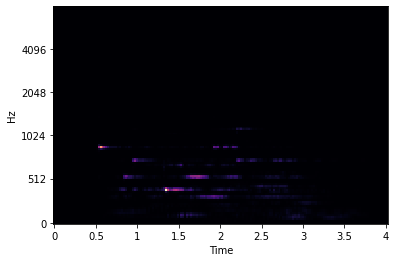

In [25]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=ta_sr1, 
                                                      n_fft=2048, 
                                                      hop_length=1024,
                                                      pad_mode='reflect',
                                                      norm=None,
                                                      mel_scale="htk",
                                                    )
ta_mel_spect=mel_spectrogram(ta_wav1)
librosa.display.specshow(ta_mel_spect.numpy()[0], y_axis='mel', fmax=8000, x_axis='time');

In [26]:
ta_mel_spect[0,0,15:20]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 7.3726e-08, 2.0400e-06])

In [27]:
lr_mel_spect[0,0,15:20]

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 7.3725730e-08,
       2.0399643e-06], dtype=float32)

通过设置相同的参数，返回的结果也相同